In [36]:
import * as nn from "../index.ts"

class Model extends nn.Module {
  seq: nn.Sequencial;
  
  constructor(input_size: number, output_size: number, hidden_dim = 10) {
    super();
    this.seq = new nn.Sequencial([
      new nn.Linear(input_size, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, output_size)
    ])
    this.register_parameters([this.seq]);
  }

  override forward(x: nn.Tensor): nn.Tensor {
    return this.seq.$(x);
  }
}


In [37]:
function create_data(start: number, end: number, num_points: number): { x: nn.Tensor, y: nn.Tensor }[] {
  const data = [];
  for (let i = 0; i < num_points; i++) {
    let x_val = start + (end - start) * i / (num_points - 1);
    let noise = (Math.random() - 0.5) * 0.2; // Adding some noise to Y
    const x = nn.Tensor.fromArray([x_val], [1, 1], false); // Input data shouldn't require gradients
    const y = new nn.Tensor([Math.cos(x.data[0]) ], [1, 1]);
    data.push({ x: x, y: y });
  }
  return data;
}


const data = create_data(-5, 5, 100);
data[0].x.data

Float32Array(1) [ -5 ]

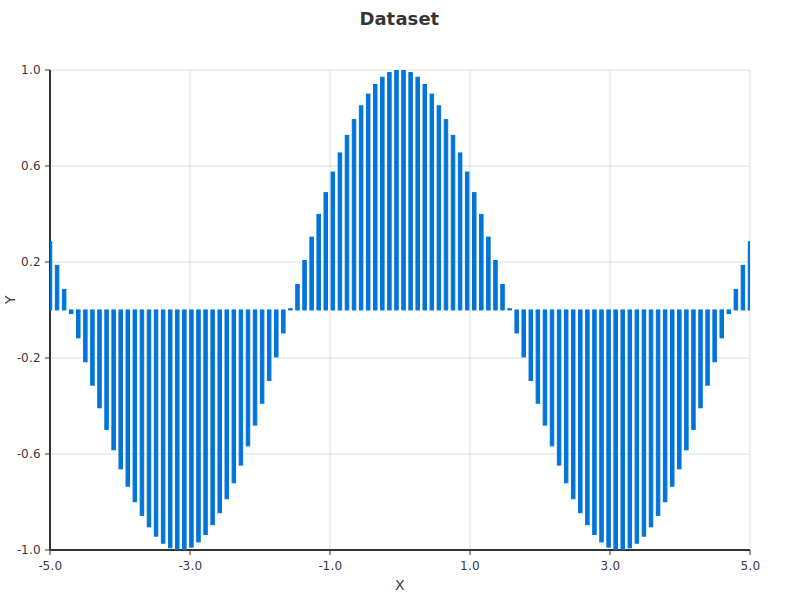

In [ ]:
import { Replot } from "../plot.ts";

let dataplt = new Replot({
  width: 800,
  height: 600,
  title: "Dataset",
  xLabel: "X",
  yLabel: "Y",
  showGrid: true
});

dataplt.addPlot("line", data.map((v) => ({ x: v.x.item(), y: v.y.item() })))
Deno.jupyter.svg`${dataplt.plot()}`

In [39]:
const model = new Model(1, 1, 40);
const optimizer = new nn.SGD(model.parameters, 0.01);

In [40]:
model.parameters_count

5041

In [41]:
let total_loss: number[] = [];
for (let i = 0; i < 1000; i++) {
  let epoch_loss: number[] = [];
  for (const { x, y } of data) {
    const output = model.$(x);
    const loss = nn.mean(nn.pow(nn.sub(output, y), 2));
    loss.backward();
    optimizer.step();
    // console.log(`Iteration ${i}, Loss: ${loss.data[0]}, Output: ${output.data[0]}, Target: ${y.data[0]}`);
    epoch_loss.push(loss.data[0]);
    optimizer.zero_grad();
  }
  let loss = epoch_loss.reduce((a, b) => a + b, 0) / epoch_loss.length
  console.log(`Epoch ${i + 1}:${100} loss:`, loss);
  epoch_loss = [];
  total_loss.push(loss)
}
console.log("Total loss:", total_loss.reduce((a, b) => a + b, 0));


Epoch 1:100 loss: 5.478711771336384


Epoch 2:100 loss: 0.3249132579058823
Epoch 3:100 loss: 0.18159049080531986
Epoch 4:100 loss: 0.09755960552993201
Epoch 5:100 loss: 0.06249673550943044
Epoch 6:100 loss: 0.049509150684224325
Epoch 7:100 loss: 0.04222050365202449
Epoch 8:100 loss: 0.03863710493009421
Epoch 9:100 loss: 0.03856372986513325
Epoch 10:100 loss: 0.042575602435687754
Epoch 11:100 loss: 0.050280113083535125
Epoch 12:100 loss: 0.060236548521661465
Epoch 13:100 loss: 0.07030879101744646
Epoch 14:100 loss: 0.07891977694289665
Epoch 15:100 loss: 0.08504300743214471
Epoch 16:100 loss: 0.08808484395617086
Epoch 17:100 loss: 0.08822535117588132
Epoch 18:100 loss: 0.08603274081126372
Epoch 19:100 loss: 0.08222748421825372
Epoch 20:100 loss: 0.07753914364602962
Epoch 21:100 loss: 0.07255091336489727
Epoch 22:100 loss: 0.06763215829829278
Epoch 23:100 loss: 0.06299594409098062
Epoch 24:100 loss: 0.058853592273917454
Epoch 25:100 loss: 0.05533289980119662
Epoch 26:100 loss: 0.05235253877719799
Epoch 27:100 loss: 0.04990841

In [42]:
const plt = new Replot({
  width: 800,
  height: 600,
  title: "Epoch Loss",
  xLabel: "Epochs",
  yLabel: "Loss",
  showGrid: true
});

plt.addPlot("line", total_loss.map((v, i) => ({ x: i, y: v })), 
  { strokeColor: "#0074d9" }, "Train Loss");

1

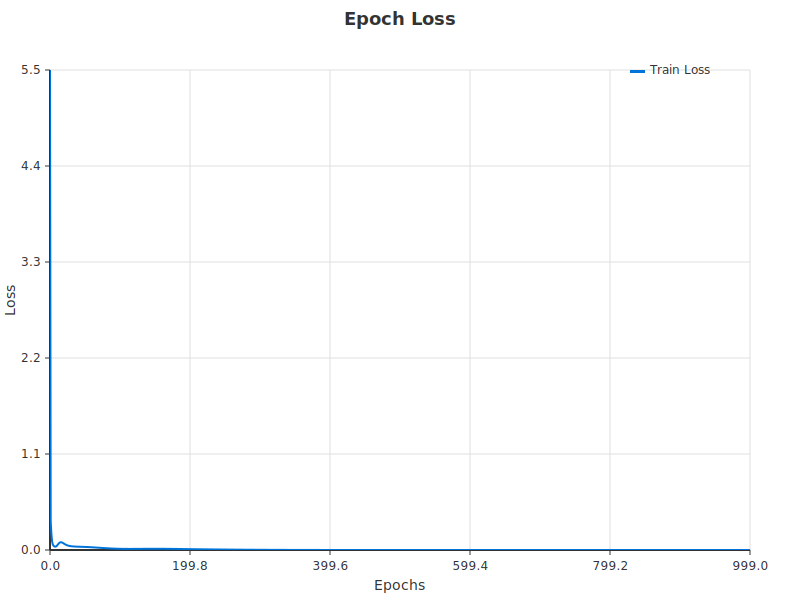

In [43]:

Deno.jupyter.svg`${plt.plot()}`

In [44]:
const pred = data.map(v => {
  return {
    x: v.x.item(),
    y: model.$(v.x).item()
  }
})

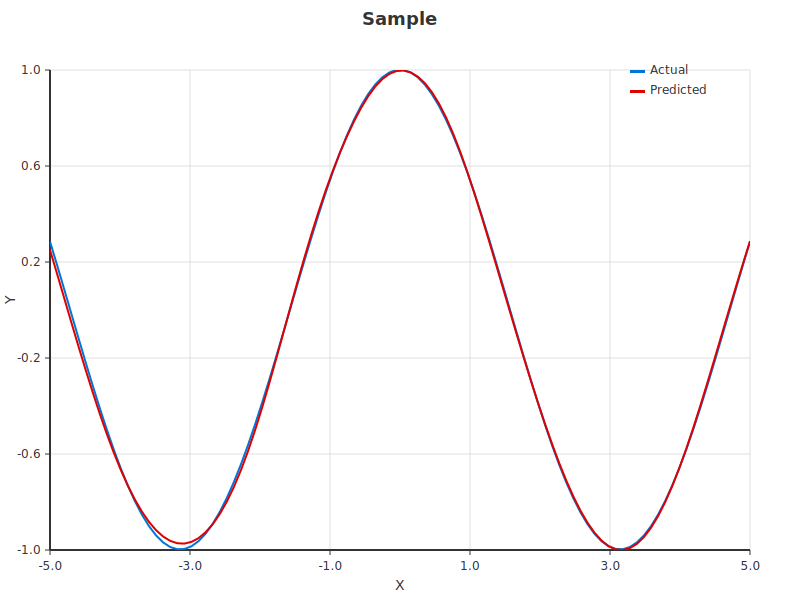

In [45]:
let out = new Replot({
  width: 800,
  height: 600,
  title: "Sample",
  xLabel: "X",
  yLabel: "Y",
  showGrid: true
});
out.addPlot("line", data.map((v) => ({ x: v.x.item(), y: v.y.item() })), { strokeColor: "#0074d9" }, "Actual")
out.addPlot("line", pred, { strokeColor: "#dF000077", }, "Predicted")
Deno.jupyter.svg`${out.plot()}`